In [1]:
# Necessary libraries

from scipy.optimize import curve_fit
from numba import njit
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import subprocess
import time
import psutil

sns.set_theme()

<h1>Speedup per number of cores</h1>

In [2]:
# initial values
n = 9 # Maximum number of points = 10^n

# number of physical and logical cores
physical_cores = psutil.cpu_count(logical=False)
logical_cores = psutil.cpu_count()

print(f"physical cores = {physical_cores}")
print(f"logical cores = {logical_cores}")

physical cores = 6
logical cores = 12


In [3]:
# compile the C program with gcc
subprocess.run(["gcc", "-o", "omp_MC_pi", "omp_MC_pi.c", "-fopenmp"])

# values
threads_list = range(1,logical_cores+1)
N = [10**i for i in range(2,n+1)]

In [4]:
# import the data or run the compiled program
try: df = pd.read_csv("cpu_time.csv")
except:
    data = [["nThreads", "N", "cpu_time"]]
    
    for threads in threads_list:
        print(threads, end="")
        
        for j in N:
            print(".",end="")
            
            start = time.time()
            result = subprocess.run(["./omp_MC_pi"], input=f"{threads}\n{j}", text=True, stdout=subprocess.PIPE)
            data.append([threads, j, time.time() - start])
            
        print()
    df = pd.DataFrame(data[1:], columns=data[0])
    
# the data
df.tail()

1........
2........
3........
4........
5........
6........
7........
8........
9........
10........
11........
12........


,nThreads,N,cpu_time
91,12,100000,0.006221
92,12,1000000,0.008525
93,12,10000000,0.041715
94,12,100000000,0.394628
95,12,1000000000,3.940811


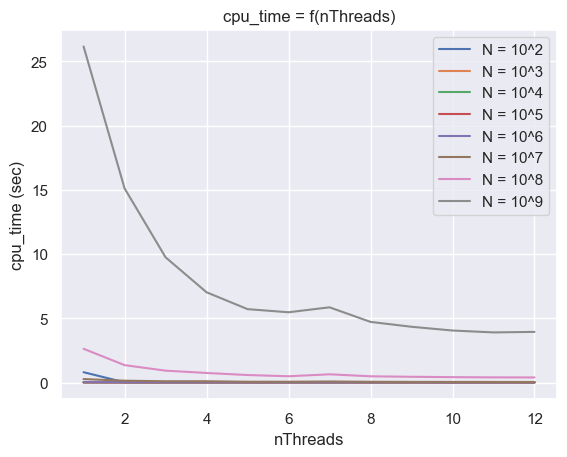

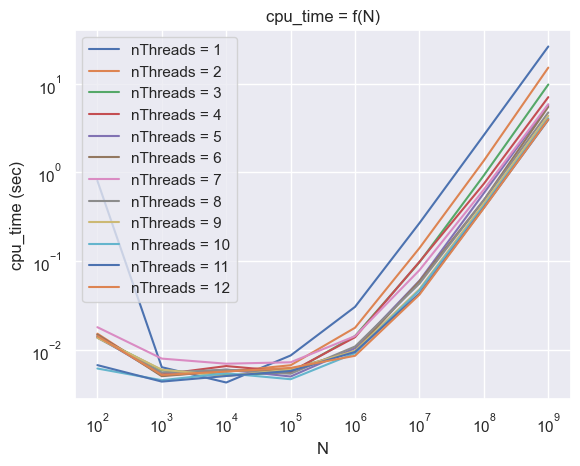

In [5]:
# plots
for i in range(2, int(np.log10(N[-1]))+1):
    sns.lineplot(data=df[df.N == 10**i], x="nThreads", y="cpu_time", label=f"N = 10^{i}")
plt.xlabel("nThreads")
plt.ylabel("cpu_time (sec)")
plt.title("cpu_time = f(nThreads)")
plt.show()

for i in range(1, threads_list[-1]+1):
    sns.lineplot(data=df[df.nThreads == i], x="N", y="cpu_time", label=f"nThreads = {i}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")
plt.ylabel("cpu_time (sec)")
plt.title("cpu_time = f(N)")
plt.legend()
plt.show()

In [6]:
# add speedup column
df["speedup"] = [df[df.iloc[i].N == df.N].cpu_time.iloc[0]/df.cpu_time.iloc[i] if df.cpu_time.iloc[i] != 0 else 0  for i in range(len(df))]

# mean speedup for eache number of threads (N => 10^7)
mean_speedup = df[df.N >= 10**8][["nThreads","speedup"]].groupby("nThreads").mean().iloc[:physical_cores]
mean_speedup.index.name = "Number of processors"
mean_speedup.rename(columns = {'speedup':'Mean speedup'}, inplace = True)
mean_speedup

,Mean speedup
Number of processors,
1,1.000000
2,1.835889
3,2.765817
4,3.630920
5,4.546887
6,5.090913


In [7]:
# Test function with coefficients as parameters
def Amdahls_law (s, p):
    return 1 / ((1 - p) + p/s)
 
# curve fit()
parameter = curve_fit(Amdahls_law, mean_speedup.index, mean_speedup["Mean speedup"])

# speedup function
S = lambda s: Amdahls_law(s, parameter[0][0])

In [8]:
print(f"The percentage of the code that benefits from parallelization is {round(parameter[0][0]*100,1)}%.")
print(f"Maximum speedup in the limit of 10000 cores is {round(S(10000),1)} times.")

The percentage of the code that benefits from parallelization is 96.7%.
Maximum speedup in the limit of 10000 cores is 30.4 times.


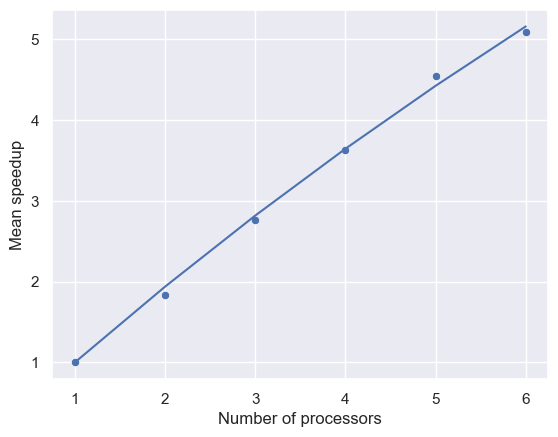

In [9]:
# speedup curve
sns.scatterplot(data=mean_speedup, x="Number of processors", y="Mean speedup")
sns.lineplot(x=mean_speedup.index, y=S(mean_speedup.index))
plt.show()

In [10]:
# export data
df.to_csv('cpu_time.csv', index=False)

<h1>Monte Carlo implementation</h1>

In [11]:
# import the data or run the compiled program
try: df2 = pd.read_csv("pi.csv")
except:
    n = 7
    N = 10**np.linspace(2, n, 1001)
    N = N.astype(int)
    lenN = len(N)
    
    df2 = pd.DataFrame(N,columns=["N"])
    df2["pi"] = np.zeros(lenN)
    pis = []
    
    #run the compiled program
    for i,j in enumerate(N):
        if lenN >= 100:
            if (i + 1) % int(lenN/10) == 0: print(f"{i+1}")
            elif (i + 1) % int(lenN/100) == 0: print(f".", end="")
        else:
            if (i + 1) % 10 == 0: print(f"{i+1}")
            elif (i + 1) % int(lenN/10) == 0: print(f".", end="")
        
        result = subprocess.run(["./omp_MC_pi"], input=f"{physical_cores}\n{j}", text=True, stdout=subprocess.PIPE)
        pis.append(float(result.stdout))
    
    df2.pi = pis
    df2["pi_error"] = np.abs(df2.pi - np.pi)
    df2["theoretical_error"] = np.sqrt(1/(df2.N +1))

# the data
df2.tail()

.........100
.........200
.........300
.........400
.........500
.........600
.........700
.........800
.........900
.........1000


,N,pi,pi_error,theoretical_error
996,9549925,3.141643,0.000050,0.000324
997,9660508,3.141697,0.000105,0.000322
998,9772372,3.141649,0.000056,0.000320
999,9885530,3.141698,0.000105,0.000318
1000,10000000,3.141758,0.000165,0.000316


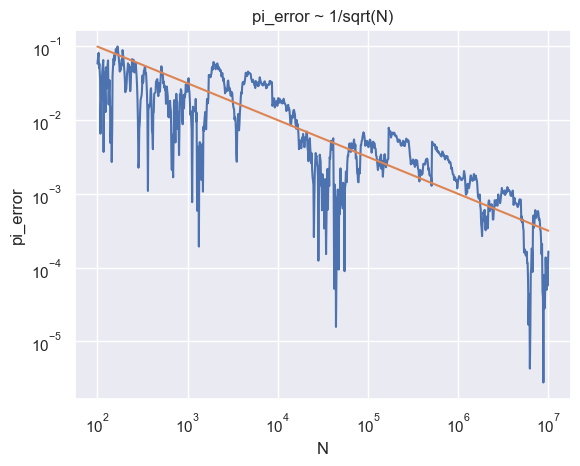

In [12]:
# plot of experimental vs expected error
sns.lineplot(data=df2, x="N", y="pi_error")
sns.lineplot(data=df2, x="N", y="theoretical_error")
plt.xlabel("N")
plt.ylabel("pi_error")
plt.title("pi_error ~ 1/sqrt(N)")
plt.xscale('log')
plt.yscale('log')
plt.show()

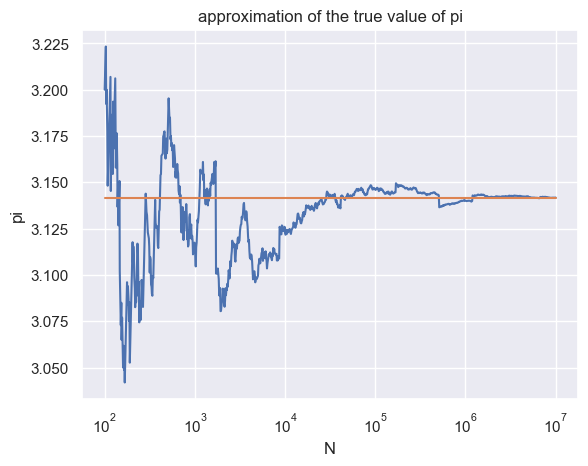

In [13]:
# plot of the approximation of the true value of pi
sns.lineplot(data=df2, x="N", y="pi")
sns.lineplot(x=N, y=np.pi)
plt.xlabel("N")
plt.ylabel("pi")
plt.title("approximation of the true value of pi")
plt.xscale('log')
plt.show()

In [14]:
# export data
df2.to_csv('pi.csv', index=False)

<h1>Comparison with Numba</h1>

In [15]:
# Monte Carlo method for calculating π
# Numba and Python fuction 

@njit
def numba_monte_carlo_pi(nsamples):
    acc = 0
    
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
            
    return 4.0 * acc / nsamples

def python_monte_carlo_pi(nsamples):
    acc = 0
    
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
            
    return 4.0 * acc / nsamples

In [16]:
# import the data or produce them
try: df3 = pd.read_csv("numba.csv")
except:
    n = 8
    N = 10**np.linspace(2, n, 21)
    N = N.astype(int)
    lenN = len(N)

    data = [["N", "numba_cpu_time", "c_code_cpu_time", "python_cpu_time"]]
    for i,j in enumerate(N):
        if lenN >= 100:
            if (i + 1) % int(lenN/10) == 0: print(f"{i+1}")
            elif (i + 1) % int(lenN/100) == 0: print(f".", end="")
        else:
            if (i + 1) % 10 == 0: print(f"{i+1}")
            elif (i + 1) % int(lenN/10) == 0: print(f".", end="")

        start_numba = time.time()
        result = numba_monte_carlo_pi(j)
        numba_cpu_time = time.time() - start_numba

        start_c_code = time.time()
        result = subprocess.run(["./omp_MC_pi"], input=f"{physical_cores}\n{j}", text=True, stdout=subprocess.PIPE)
        c_code_cpu_time = time.time() - start_c_code

        start_python = time.time()
        result = python_monte_carlo_pi(j)
        python_cpu_time = time.time() - start_python
        
        data.append([j, numba_cpu_time, c_code_cpu_time, python_cpu_time])
        
    df3 = pd.DataFrame(data[1:], columns=data[0])

# the data
df3.tail()

....10
....20


,N,numba_cpu_time,c_code_cpu_time,python_cpu_time
16,6309573,0.055786,0.054000,1.824471
17,12589254,0.110355,0.073683,3.643729
18,25118864,0.222166,0.167962,7.236868
19,50118723,0.432229,0.252359,14.454934
20,100000000,0.861100,0.511374,28.458080


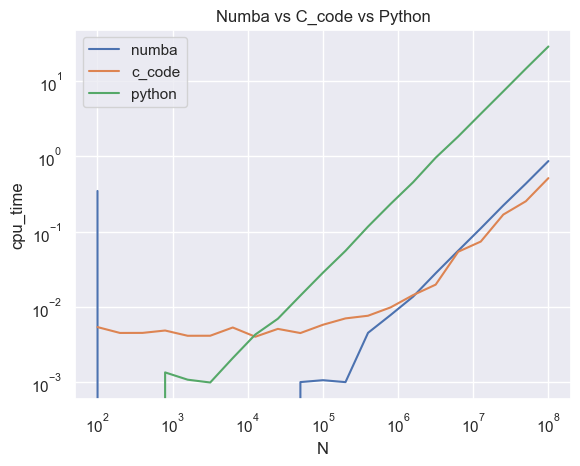

In [17]:
# plot, comparison between Numba, C code and Python
sns.lineplot(data=df3, x="N", y="numba_cpu_time", label="numba")
sns.lineplot(data=df3, x="N", y="c_code_cpu_time", label="c_code")
sns.lineplot(data=df3, x="N", y="python_cpu_time", label="python")
plt.xlabel("N")
plt.ylabel("cpu_time")
plt.title("Numba vs C_code vs Python")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
numba_t = df3.iloc[-1].numba_cpu_time
c_code_t = df3.iloc[-1].c_code_cpu_time
python_t = df3.iloc[-1].python_cpu_time/physical_cores

print(f"Numba is {(python_t - numba_t)*100/numba_t :.1f}% faster than Python.")
print(f"C code is {(python_t - c_code_t)*100/c_code_t :.1f}% faster than Python.")
print(f"C code is {(numba_t - c_code_t)*100/c_code_t :.1f}% faster than Numba.")

Numba is 450.8% faster than Python.
C code is 827.5% faster than Python.
C code is 68.4% faster than Numba.


In [19]:
# export data
df3.to_csv('numba.csv', index=False)